# Library imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.dae import *

from scipy.integrate import odeint, solve_ivp
from scipy.interpolate import CubicSpline
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Helper functions

In [2]:
# This function defines a system of ordinary differential equations (ODEs)
# that models microbial growth, substrate consumption, and maintenance.
# The parameters and equations are based on biological and kinetic assumptions.

def combined_ode_system(t, y, y0_g):
    # Unpacking the state variables
    Xv, Xd, Cg, Cm, Cc = y  # Xv: viable cells, Xd: dead cells, Cg: glucose concentration, Cm: metabolic byproduct, Cc: cofactor concentration

    # Defining model parameters with scientific notation conversions
    mu_g_max = (0.74) * 10**-0.75  # Maximum specific growth rate of the cells
    Kg = (0.2) * 10**2  # Half-saturation constant for glucose uptake

    mu_c_death = (0.06) * 10**0.25  # Death rate constant
    Kc = (1) * 10**1.5  # Half-saturation constant for cofactor-dependent death rate

    k_d = (0.001) * 10**1  # Baseline death rate constant

    Y_xg = (0.052) * 10**0  # Yield coefficient of biomass on glucose

    m_k = (0.06) * 10**-2  # Maintenance energy coefficient
    k_c_maint = (0.03) * 10**0  # Cofactor maintenance constant

    Y_mx = (20) * 10**-1  # Yield coefficient of metabolic byproduct formation
    beta = (5) * 10**-0.75  # Additional metabolic byproduct term

    kc = 10**1.5  # Cofactor saturation constant for metabolic byproduct formation

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Growth rate calculations

    mu_g = 2 * ((mu_g_max * Cg) / (Kg + Cg))  # Monod-type growth function

    Xm = Y_xg * y0_g  # Maximum biomass capacity based on initial glucose

    log_x = (1 - (Xv / Xm))  # Logistic growth limitation due to space/nutrient constraints

    mu_growth = mu_g * log_x  # Effective growth rate incorporating nutrient limitations

    # Death rate calculations
    mu_death = k_d + ((mu_c_death * Cc) / (Kc + Cc)) / 2  # Death rate depends on cofactor concentration

    # Maintenance energy consumption
    maint_gc = (m_k * Cc) / (k_c_maint + Cc)  # Maintenance energy requirement function

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Defining the system of differential equations

    dXvdt = (mu_growth - mu_death) * Xv  # Change in viable cell population

    dXddt = mu_death * Xv  # Accumulation of dead cells

    dCgdt = -1 * (mu_growth / Y_xg) * Xv - maint_gc * Xv  # Glucose consumption

    dCmdt = Y_mx * (mu_growth + beta) * Xv * (Cc / (Cc + kc))  # Production of metabolic byproduct

    dCcdt = -1 * dCmdt  # Cofactor consumption (assumed to be in a 1:1 ratio with metabolic byproduct)

    return [dXvdt, dXddt, dCgdt, dCmdt, dCcdt]  # Returning the derivatives as a list


In [3]:
# Initial conditions for the ODE system
y0 = np.array([0.1, 0.0, 82, 0, 20])  
# y0[0] = 0.1  -> Initial viable cell concentration (Xv)
# y0[1] = 0.0  -> Initial dead cell concentration (Xd)
# y0[2] = 82   -> Initial glucose concentration (Cg)
# y0[3] = 0    -> Initial metabolic byproduct concentration (Cm)
# y0[4] = 20   -> Initial cofactor concentration (Cc)

tspan = (0, 72)  # Time span for the simulation (from 0 to 72 hours)

# Solve the system of ODEs using the Radau method (suitable for stiff problems)
sol = solve_ivp(
    combined_ode_system,  # Function defining the ODE system
    tspan,                # Time range for the integration
    y0,                   # Initial conditions
    args=tuple([y0[2]]),  # Passing the initial glucose concentration as an argument (y0_g)
    method="Radau"        # Using Radau, an implicit solver for stiff problems
)

# Copy the solution for reference
y_true = np.copy(sol.y)  # Stores the true solution before any modifications

# Modify the solution to combine viable and dead cells into a single state
y_act = sol.y
y_act[0, :] = y_act[0, :] + y_act[1, :]  # Summing viable (Xv) and dead (Xd) cell populations

# Remove the second row (Xd) after summing it into Xv
y_act1 = np.delete(y_act, 1, axis=0)  # Deleting the second row (Xd) from the array


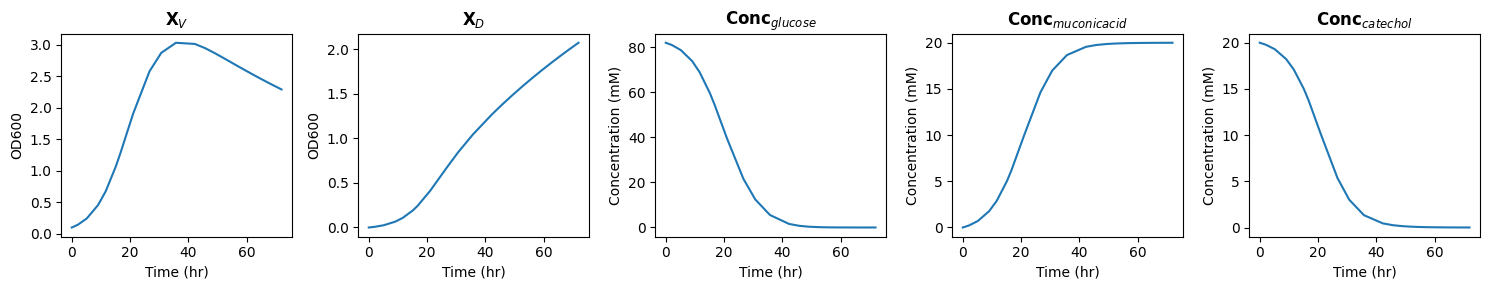

In [4]:
fig, axs = plt.subplots(1,5, figsize = (15,3))
ax = axs.ravel()

Name = ["X$_V$","X$_D$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_true)):
    ax[i].plot(sol.t, y_true[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

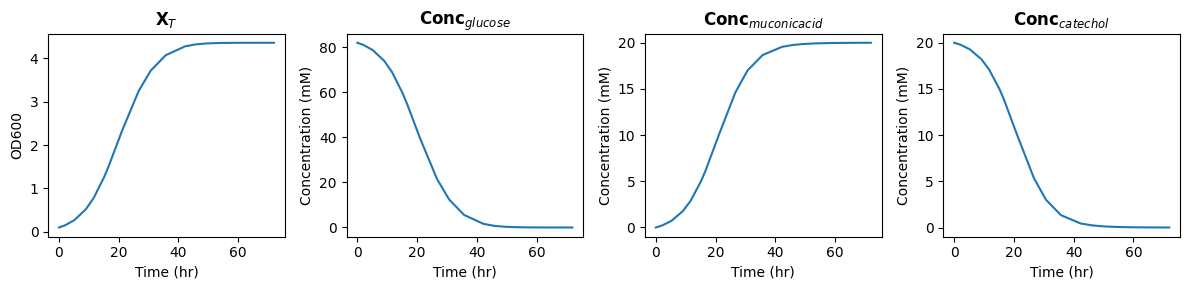

In [5]:
fig, axs = plt.subplots(1, 4, figsize = (12, 3))
ax = axs.ravel()
Name = ["X$_T$", "Conc$_{glucose}$", "Conc$_{muconic acid}$", "Conc$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for i in range(len(y_act1)):
    ax[i].plot(sol.t, y_act1[i,:])
    ax[i].set_xlabel("Time (hr)")
    ax[i].set_ylabel(ylabels[i])
    ax[i].set_title(Name[i], fontweight = "bold")

plt.tight_layout()

In [6]:
def syn_data_generation(num_points, file_name):
    """
    This function generates synthetic training data for a 72-hour batch bioprocess.
    It solves the ODE system for different initial conditions provided in a file.
    
    Parameters:
    - num_points (int): Number of time points for evaluation.
    - file_name (str): Name of the file containing different initial conditions.
    
    Returns:
    - time (numpy array): Time points at which the solution is evaluated.
    - sol_dict (dict): Dictionary containing simulated state trajectories for each set of initial conditions.
    """
    
    # Define the directory path to the initial conditions file
    dir_n = "Initial_conditions\\" + file_name  
    
    # Load the initial conditions from the specified file
    Init_cond = np.loadtxt(dir_n)  

    # Initialize dictionaries to store solutions and other parameters
    sol_dict = {}  # Stores simulation results for different initial conditions
    mu_dict = {}   # (Not used in this function, but could store growth rates if needed)

    # Loop through each set of initial conditions
    for i in range(len(Init_cond)):
        
        y0 = Init_cond[i, :]  # Extract initial conditions for this iteration
        tspan = (0, 72)  # Define the simulation time span (0 to 72 hours)
        teval = np.linspace(tspan[0], tspan[1], num_points)  # Generate time points for evaluation
        
        # Solve the ODE system using the Radau method (for stiff systems)
        sol = solve_ivp(
            combined_ode_system,  # ODE function
            tspan,                # Time range
            y0,                   # Initial conditions
            args=tuple([y0[2]]),  # Passing the initial glucose concentration as an argument
            method="Radau",       # Implicit solver for stiff ODEs
            t_eval=teval          # Specify time points for evaluation
        )
        
        # Process the solution data
        y_act = sol.y
        y_act[0, :] = y_act[0, :] + y_act[1, :]  # Combine viable (Xv) and dead (Xd) cell counts
        y_act = np.delete(y_act, 1, axis=0)  # Remove the dead cell row (Xd) after merging

        # Store the processed solution in the dictionary
        sol_dict[i] = y_act
        
        time = sol.t  # Store the time points for reference
    
    return [time, sol_dict]  # Return the time points and the dictionary of solutions

In [7]:
def Error_addition(num_points, file_name, per_err, rs=10):
    """
    This function generates synthetic training data using the ODE solver, then adds Gaussian noise (error) 
    to the resulting concentration profiles to simulate real-world data variation.
    
    Parameters:
    - num_points (int): Number of time points for evaluation.
    - file_name (str): Name of the file containing initial conditions.
    - per_err (float): The percentage error to be added to the data (as a proportion).
    - rs (int): Random seed for reproducibility (default is 10).
    
    Returns:
    - time (numpy array): Time points at which the solution is evaluated.
    - retreived_conc_dict (dict): Dictionary with noisy concentration profiles for each initial condition.
    """
    
    # Set the random seed for reproducibility
    random_seed = rs  
    
    # Generate the synthetic training data using the function 'syn_data_generation'
    time, s_dict = syn_data_generation(num_points, file_name)  
    
    # Extract the shape of the concentration profiles (number of species, number of time points)
    num_sp, num_t = np.shape(s_dict[0])

    # Dictionary to store the noisy concentration profiles
    retreived_conc_dict = {}

    # Iterate over each initial condition (batch run) to add error
    for i in range(len(s_dict.keys())):
        
        np.random.seed(random_seed + i)  # Ensure each batch gets a different seed for randomness
        
        # Generate Gaussian noise (random error) with mean 0 and standard deviation 'per_err'
        D_err = np.random.normal(0, per_err, size=(num_sp, num_t)) / 100
        
        # Get the concentration profiles for the current set of initial conditions
        conc_profiles = s_dict[i]
        
        # Apply the error (element-wise multiplication of concentrations and noise)
        D_final = conc_profiles + np.multiply(conc_profiles, D_err)  # Add noise to the profiles

        # Store the noisy concentration profiles in the dictionary
        retreived_conc_dict[i] = D_final

    # Return the time points and the dictionary containing the noisy concentration profiles
    return [time, retreived_conc_dict]

In [8]:
file_name = "Initial_conditions_3_1_PP.txt"
time, s = syn_data_generation(10, file_name)
t, rc = Error_addition(10,file_name, 10, rs = 5)

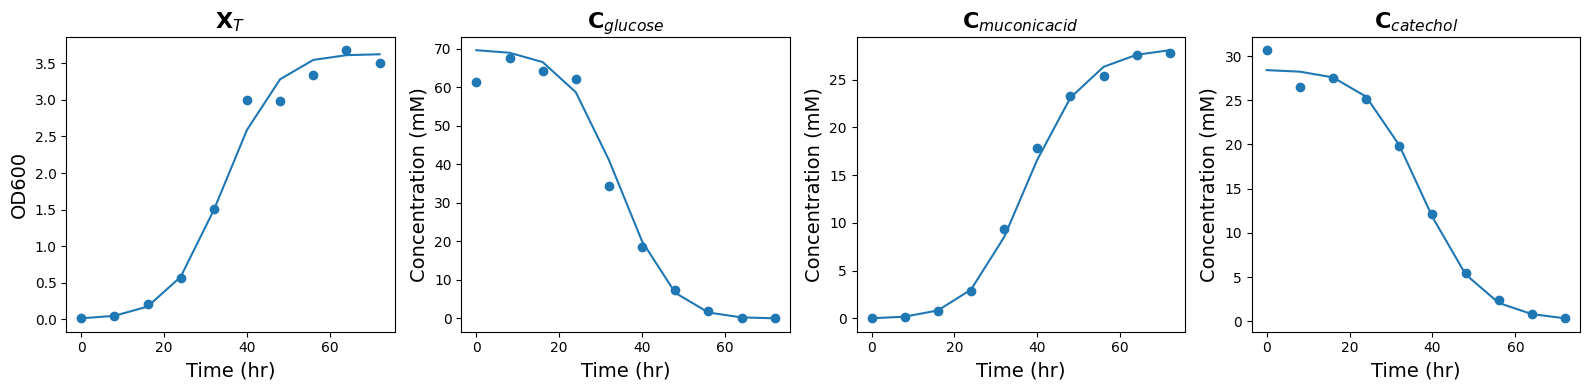

In [9]:
i = 0

fig, axs = plt.subplots(1,4,figsize = (16,4))
ax = axs.ravel()
Name = ["X$_T$", "C$_{glucose}$", "C$_{muconic acid}$", "C$_{catechol}$"]
ylabels = ["OD600", "Concentration (mM)", "Concentration (mM)", "Concentration (mM)"]

for j in range(4):
    ax[j].plot(time, s[i][j])
    ax[j].scatter(t, rc[i][j])
    ax[j].set_xlabel("Time (hr)", fontsize = 14)
    ax[j].set_ylabel(ylabels[j], fontsize = 14)
    ax[j].set_title(Name[j], fontweight = "bold", fontsize = 16)

plt.tight_layout()

# Integrated Model Construction

In [10]:
def ANN_int_mu_model(model, d, t):
    """
    This function represents an integrated Artificial Neural Network (ANN) model 
    that will be embedded within a Pyomo formulation.
    
    Parameters:
    model: Pyomo model containing ANN parameters and variables
    d: Index representing a specific data point or scenario
    t: Index representing a specific time step
    
    Returns:
    h3: Output of the ANN model at the given indices (d, t)
    """

    # Extracting input variables from the Pyomo model
    Xt = model.conc_Xt[d, t]  # Concentration of Xt
    Cg = model.conc_Cg[d, t]  # Concentration of Cg
    Cm = model.conc_Cm[d, t]  # Concentration of Cm
    Cc = model.conc_Cc[d, t]  # Concentration of Cc

    h1_list = []  # List to store activations of the first hidden layer

    # Calculating the first hidden layer activations
    for i in model.h1_num_nod:
        # Weighted sum of inputs plus bias for each node in the first hidden layer
        z1 = (
            model.W1[0, i] * Xt +
            model.W1[1, i] * Cg +
            model.W1[2, i] * Cm +
            model.W1[3, i] * Cc +
            model.b1[i]
        )
        
        # Activation function (Sigmoid function used here)
        h1 = 1 / (1 + math.e ** (-1 * z1))  
        # Alternative activation function (commented out):
        # h1 = (math.e**(2*z1) - 1) / (math.e**(2*z1) + 1)  # Tanh activation function
        
        h1_list.append(h1)  # Storing the computed activation

    # Calculating the output layer activation
    z2 = model.b2  # Initializing with bias term
    for i in model.h1_num_nod:
        z2 += model.W2[i] * h1_list[i]  # Weighted sum of hidden layer activations

    h3 = z2  # Output of the ANN model
    
    return h3  # Returning the final output

In [11]:
def dXtdt_int_con(model, d, t):
    # Defines a constraint for the total biomass dynamics in an ODE system
    if t == 0:
        return Constraint.Skip  # Skips the constraint at the initial time step
    mu = ANN_int_mu_model(model, d, t)  # Computes the specific growth rate using an ANN model
    return model.dXtdt[d, t] == mu * model.conc_Xt[d, t]  # Defines the biomass growth rate equation

def dCgdt_int_con(model, d, t):
    # Defines a constraint for glucose concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip  # Skips the constraint at the initial time step
    mu = ANN_int_mu_model(model, d, t)  # Computes the specific growth rate using an ANN model    
    # Defines the glucose consumption rate equation
    return model.dCgdt[d, t] == -1 * model.conc_Xt[d, t] * (mu * model.Ygx) * (model.max_vals[0] / model.max_vals[1])

def dCmdt_int_con(model, d, t):
    # Defines a constraint for muconic acid concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip  # Skips the constraint at the initial time step
    mu = ANN_int_mu_model(model, d, t)  # Computes the specific growth rate using an ANN model
    # Defines the muconic acid production rate equation
    return model.dCmdt[d, t] == (model.Ymx * mu + model.beta) * model.conc_Xt[d, t] * (
        (model.conc_Cc[d, t]) / (model.conc_Cc[d, t] + (model.kc / model.max_vals[3]))
    ) * (model.max_vals[0] / model.max_vals[2])

def dCcdt_int_con(model, d, t):
    # Defines a constraint for catechol concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip  # Skips the constraint at the initial time step
    # Defines the catechol consumption rate equation
    return model.dCcdt[d, t] == -1 * model.dCmdt[d, t] * (model.max_vals[2] / model.max_vals[3])

def objective_int_SSmse(model):
    # Defines a state-space objective function for the integrated hybrid model
    # This function calculates the mean squared error (MSE) between measured and simulated concentrations
    final = 0  # Initializes the cumulative error
    # Loops over all spatial indices (d_idx) and measured time points (t_meas)
    for i in model.d_idx:
        for j in model.t_meas:
            # Accumulates squared errors for each state variable: biomass (Xt), glucose (Cg),
            # muconic acid (Cm), and catechol (Cc)
            final += (model.conc_Xt_meas[i, j] - model.conc_Xt[i, j])**2
            final += (model.conc_Cg_meas[i, j] - model.conc_Cg[i, j])**2
            final += (model.conc_Cm_meas[i, j] - model.conc_Cm[i, j])**2
            final += (model.conc_Cc_meas[i, j] - model.conc_Cc[i, j])**2
    # Computes the mean squared error by normalizing the total error
    # The denominator accounts for four state variables, the number of spatial indices, and time points
    fin = final / (4 * len(model.d_idx) * len(model.t_meas))
    return fin  # Returns the computed mean squared error

In [12]:
def make_model_int_rs_fl(rs, fl):
    """
    This function generates a Pyomo model for a bioprocess using a hybrid ODE-ANN approach. 
    The function performs the following tasks:
    1. Generates training data with initial conditions and error added using predefined functions.
    2. Scales the data for model training.
    3. Defines a Pyomo model with sets, parameters, variables, and constraints based on the training data.
    4. Uses a solver to find optimal values for the model parameters.

    Parameters:
    - rs: Random seed for data generation (for reproducibility).
    - fl: Filename that contains initial conditions for the training data.

    Returns:
    - max_vals: The maximum values used for scaling the data.
    - model: The Pyomo model object representing the ODE-ANN system.
    """

    num = 10  # Number of time points per initial condition
    err = 10  # Percentage of Gaussian noise to be added
    rs = rs   # Use the random seed specified

    # Generate the synthetic training data using the functions `syn_data_generation` and `Error_addition`.
    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    # Collect data for each concentration (Xt, Cg, Cm, Cc) into a temporary list.
    y_temp = []
    for i in range(3):  # Loop for the first three species (Xt, Cg, Cm)
        y_temp.append(rc[i])

    # Convert the temporary data into numpy arrays for easier manipulation
    no_touch_y = np.array(y_temp)
    no_touch_t = np.copy(t)

    # Get the shape of the data (dimensions for species, datasets, and time points)
    n_d, n_s, n_t = np.shape(no_touch_y)

    # Extract the time and species data
    t = no_touch_t
    y_temp = no_touch_y
    max_vals = np.max(np.max(no_touch_y, axis=0), axis=1)  # Get the maximum values for scaling

    # Scale the data for training purposes
    y_scaled = np.zeros(np.shape(y_temp))

    # Create dictionaries for each concentration to store data in a format that Pyomo can use
    Xt_dict = {}
    Cg_dict = {}
    Cm_dict = {}
    Cc_dict = {}

    # Normalize each concentration by dividing by its max value
    for j in range(n_d):
        for i in range(n_t):
            Xt_dict[(j, t[i])] = y_temp[j, 0, i] / max_vals[0]
            y_scaled[j, 0, i] = y_temp[j, 0, i] / max_vals[0]

            Cg_dict[(j, t[i])] = y_temp[j, 1, i] / max_vals[1]
            y_scaled[j, 1, i] = y_temp[j, 1, i] / max_vals[1]

            Cm_dict[(j, t[i])] = y_temp[j, 2, i] / max_vals[2]
            y_scaled[j, 2, i] = y_temp[j, 2, i] / max_vals[2]

            Cc_dict[(j, t[i])] = y_temp[j, 3, i] / max_vals[3]
            y_scaled[j, 3, i] = y_temp[j, 3, i] / max_vals[3]

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Initialize the Pyomo model
    num_nodes = 1  # Number of nodes in the hidden layer of the ANN
    model = ConcreteModel()

    # Define sets describing the dataset
    model.d_idx = Set(initialize=range(n_d))  # Batch indices
    model.t_meas = Set(initialize=no_touch_t)  # Time indices

    # Define sets for the integrated ANN structure
    model.h1_num_nod = Set(initialize=range(num_nodes))  # Hidden layer nodes
    model.num_inputs = Set(initialize=range(n_s))  # Input variables (species concentrations)

    # Parameters: Maximum values for scaling, and measured concentration data
    model.max_vals = Param(range(4), initialize=max_vals)
    model.conc_Xt_meas = Param(model.d_idx, model.t_meas, initialize=Xt_dict)
    model.conc_Cg_meas = Param(model.d_idx, model.t_meas, initialize=Cg_dict)
    model.conc_Cm_meas = Param(model.d_idx, model.t_meas, initialize=Cm_dict)
    model.conc_Cc_meas = Param(model.d_idx, model.t_meas, initialize=Cc_dict)

    # Variables - Time invariant parameters related to the bioprocess
    model.Ygx = Var(within=NonNegativeReals)
    model.Ymx = Var(within=NonNegativeReals)
    model.beta = Var(within=NonNegativeReals)
    model.kc = Var(within=NonNegativeReals)

    # Variables for species concentrations and their derivatives
    model.time = ContinuousSet(initialize=model.t_meas, bounds=(0, 72))  # Time range (0 to 72 hours)

    model.conc_Xt = Var(model.d_idx, model.time, within=NonNegativeReals)  # Biomass concentration
    model.conc_Cg = Var(model.d_idx, model.time, within=NonNegativeReals)  # Glucose concentration
    model.conc_Cm = Var(model.d_idx, model.time, within=NonNegativeReals)  # Muconic acid concentration
    model.conc_Cc = Var(model.d_idx, model.time, within=NonNegativeReals)  # Catechol concentration

    # Derivative variables for each concentration
    model.dXtdt = DerivativeVar(model.conc_Xt, within=Reals)
    model.dCgdt = DerivativeVar(model.conc_Cg, within=Reals)
    model.dCmdt = DerivativeVar(model.conc_Cm, within=Reals)
    model.dCcdt = DerivativeVar(model.conc_Cc, within=Reals)

    # Variables for ANN weights and biases (used in growth rate calculations)
    model.W1 = Var(model.num_inputs, model.h1_num_nod, bounds=(-1, 1))
    model.b1 = Var(model.h1_num_nod, bounds=(-1, 1))
    model.W2 = Var(model.h1_num_nod, bounds=(-1, 1))
    model.b2 = Var(bounds=(-1, 1))

    # Constraints - Hybrid ODEs for each species (biomass, glucose, muconic acid, catechol)
    model.deriv_Xt = Constraint(model.d_idx, model.time, rule=dXtdt_int_con)
    model.deriv_Cg = Constraint(model.d_idx, model.time, rule=dCgdt_int_con)
    model.deriv_Cm = Constraint(model.d_idx, model.time, rule=dCmdt_int_con)
    model.deriv_Cc = Constraint(model.d_idx, model.time, rule=dCcdt_int_con)

    # Objective - State space MSE (Mean Squared Error) for model fitting
    model.obj = Objective(expr=objective_int_SSmse)

    # Discretizer for Pyomo.DAE (Differential-Algebraic Equations)
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(model, nfe=n_t, ncp=2, scheme='LAGRANGE-RADAU')  # Apply Lagrange-Radau collocation method

    # Solver setup - Multistart solver (for better convergence in nonlinear models)
    solver = SolverFactory("multistart")
    results = solver.solve(model, suppress_unbounded_warning=True, iterations=50)

    # Print solver status and results
    print("Solver status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
    print(value(model.obj))  # Print the objective function value

    # Return the model and max values for future scaling or testing
    return [max_vals, model]

In [13]:
def TIV_and_ANN_int_params(model):
    """
    Extracts the time-invariant parameters and ANN weights/biases from an integrated Pyomo model.
    
    Parameters:
    - model: The integrated Pyomo model, which includes both ODEs and the embedded ANN.
    
    Returns:
    - TIV_params: Dictionary containing time-invariant model parameters (Ygx, Ymx, beta, kc).
    - ANN_params: Dictionary containing the ANN weights and biases (W1, b1, W2, b2).
    """
    
    TIV_params = {}

    # Extract time-invariant parameters from the model and store them in a dictionary
    TIV_params["Ygx"] = value(model.Ygx)  # Yield coefficient for glucose consumption
    TIV_params["Ymx"] = value(model.Ymx)  # Yield coefficient for muconic acid production
    TIV_params["beta"] = value(model.beta)  # Growth-associated production rate for muconic acid
    TIV_params["kc"] = value(model.kc)  # Constant associated with catechol consumption

    ANN_params = {}

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    # Initialize arrays for the ANN weights and biases
    W1 = np.zeros((len(model.num_inputs), len(model.h1_num_nod)))  # Input-to-hidden layer weights
    b1 = np.zeros((len(model.h1_num_nod), 1))  # Hidden layer biases
    W2 = np.zeros((len(model.h1_num_nod), 1))  # Hidden-to-output layer weights

    # Extract the values for weights and biases from the model
    for i in model.num_inputs:
        for j in model.h1_num_nod:
            W1[i, j] = value(model.W1[i, j])  # Weight for input-to-hidden layer connection

    for i in model.h1_num_nod:
        b1[i] = value(model.b1[i])  # Bias for the hidden layer
        W2[i] = value(model.W2[i])  # Weight for hidden-to-output layer connection

    # Store the extracted weights and biases in the ANN_params dictionary
    ANN_params["W1"] = W1
    ANN_params["b1"] = b1
    ANN_params["W2"] = W2
    ANN_params["b2"] = value(model.b2)  # Bias for the output layer

    # Return the extracted parameters
    return [TIV_params, ANN_params]

## Integrated model assembly and testing

In [14]:
def ANN_int_growth_model(y, ANN_params):
    # This function calculates the total biomass growth rate using an artificial neural network (ANN)
    # It takes inputs: Xt (biomass concentration), Cg (glucose concentration), Cm (muconic acid concentration),
    # Cc (catechol concentration), and the weights and biases of the ANN
    
    Xt, Cg, Cm, Cc = y  # Extract input values from the input vector y
    
    # Extract weights and biases from the ANN parameters dictionary
    W1 = ANN_params["W1"]
    b1 = ANN_params["b1"]
    W2 = ANN_params["W2"]
    b2 = ANN_params["b2"]
    
    h1_list = []  # List to store the outputs of the first hidden layer
    
    # Compute the outputs of the first hidden layer (h1) using the inputs and the ANN weights/biases
    for i in range(np.shape(b1)[0]):
        # Compute the weighted sum (z1) for each neuron in the first hidden layer
        z1 = W1[0, i] * Xt + W1[1, i] * Cg + W1[2, i] * Cm + W1[3, i] * Cc + b1[i, 0]
        # Apply the sigmoid activation function to z1
        h1 = (1 / (1 + math.e**(-1 * z1)))  # Sigmoid activation function
        h1_list.append(h1)  # Store the output of the hidden layer neuron
    
    # Compute the output (z2) of the second layer
    z2 = b2
    for i in range(np.shape(W2)[0]):
        # Compute the weighted sum for the output layer
        z2 += W2[i, 0] * h1_list[i]
    
    # Return the final output, which is the total biomass growth rate (h3)
    h3 = z2
    return h3

In [15]:
def Int_HM_ODE(t, y, param_dict, ANN_params, max_vals):
    # Defines the system of ODEs that simulate the hybrid model
    # and return the rates of change for the species in the system
    
    Xt, Cg, Cm, Cc = y  # Extracts the current concentrations of biomass (Xt),
                         # glucose (Cg), muconic acid (Cm), and catechol (Cc)
    
    # Extracts relevant parameters from the parameter dictionary
    Ygx = param_dict["Ygx"]  # Yield coefficient for glucose consumption
    Ymx = param_dict["Ymx"]  # Yield coefficient for muconic acid production
    beta = param_dict["beta"]  # Basal production rate for muconic acid
    kc = param_dict["kc"]  # Saturation constant for catechol inhibition
    
    # Computes the specific growth rate (mu) using the ANN model
    mu = ANN_int_growth_model(y, ANN_params)
    
    # Defines the differential equations for the system:
    
    # Rate of change of biomass concentration
    dXtdt = mu * Xt
    
    # Rate of change of glucose concentration
    dCgdt = -1 * Xt * (mu * Ygx) * (max_vals[0] / max_vals[1]) 
    
    # Rate of change of muconic acid concentration
    dCmdt = (Ymx * mu + beta) * Xt * ((Cc) / (Cc + (kc / max_vals[3]))) * (max_vals[0] / max_vals[2])
    
    # Rate of change of catechol concentration (which is consumed as muconic acid is produced)
    dCcdt = -1 * dCmdt
    
    # Returns the list of rates of change for each species
    return [dXtdt, dCgdt, dCmdt, dCcdt]

In [16]:
def Int_HM_Org_model_comparison_time(y0, tdict, adict, max_vals): 
    # This function simulates a batch extrapolation scenario for a given initial condition
    # and compares the integrated hybrid model's predictions with the ground truth model.
    # It returns the R2 value (coefficient of determination) as a measure of model fit.
    
    y0 = y0  # Initial conditions for the system
    y0_4 = np.delete(y0, 1)  # Removes the second element from the initial conditions (possibly corresponding to glucose)
    tspan = (0, 200)  # Defines the time span for the simulation
    
    # Solves the ground truth ODE system using the actual model
    # It integrates over the time span, using the initial condition y0[2] as an argument for the ground truth model
    sol_actual = solve_ivp(combined_ode_system, tspan, y0, args=tuple([y0[2]]),
                           method="Radau", t_eval=np.linspace(tspan[0], tspan[1], 60))
    y_actual = sol_actual.y  # Extracts the solution (species concentrations)
    
    # Adjusts the biomass concentration by adding back the deleted glucose concentration component
    y_actual[0, :] = y_actual[0, :] + y_actual[1, :]
    
    # Deletes the second row (possibly glucose) to match the format used in predictions
    y_actual = np.delete(y_actual, 1, axis=0)
    
    # Scales the initial condition by the maximum values for normalization
    y0_scaled = np.divide(y0_4, max_vals)
    
    # Solves the integrated hybrid model ODE system (predicted model)
    # Uses the scaled initial conditions and the provided parameter dictionaries (tdict, adict)
    sol_predict = solve_ivp(Int_HM_ODE, tspan, y0_scaled, args=tuple([tdict, adict, max_vals]),
                            method="Radau", t_eval=np.linspace(tspan[0], tspan[1], 60))
    y_predict = np.multiply(sol_predict.y, max_vals.reshape(-1, 1))  # Rescales the predicted output
    
    r2_list = []  # List to store R2 scores for each species
    
    # Loops through each species and calculates the R2 score between actual and predicted values
    for j in range(4):
        r2_list.append(r2_score(y_actual[j, :], y_predict[j, :]))
    
    # Returns the mean R2 score across all species, which indicates the overall model performance
    return np.mean(r2_list)

In [17]:
def Int_HM_Org_model_comparison_FB(y0, tdict, adict, max_vals): 
    # This function simulates a semi-batch extrapolation scenario for the integrated hybrid ODE model
    # The semi-batch process involves periodic glucose and catechol spikes at specific time intervals
    # It compares the predictions from the integrated hybrid model to the ground truth model and returns the R2 value
    
    y0 = y0  # Initial conditions for the system
    y0_4 = np.delete(y0, 1)  # Removes the second element (likely glucose) from the initial condition for the scaled model
    tspan = (0, 200)  # Defines the overall simulation time span
    
    sol_list = []  # List to store solutions from the ground truth ODE system
    t_init = 0  # Initial time for each semi-batch
    t_fin = 25  # Final time for each semi-batch (periodic input spikes every 25 hours)
    count = 0  # Counter for the number of input spikes
    y0_org = y0[2]  # Stores the initial concentration of muconic acid
    
    # Loop to simulate the semi-batch process, iterating through multiple 25-hour periods
    while t_fin <= tspan[-1]:
        # Solves the ground truth ODE system for each 25-hour period with a glucose and catechol spike
        sol_actual = solve_ivp(combined_ode_system, (t_init, t_fin), y0, args=tuple([y0_org + 10 * count]),
                               method="Radau", t_eval=np.linspace(t_init, t_fin, 10))
        
        sol_list.append(sol_actual)  # Adds the solution to the list
        
        y0 = np.copy(sol_actual.y[:, -1])  # Updates the initial condition for the next iteration
        y0[2] += 10  # Adds glucose spike
        y0[-1] += 3  # Adds catechol spike
        
        t_init += 25  # Updates time for the next semi-batch period
        t_fin += 25  # Updates final time for the next semi-batch period
    
    # Collects the results from all time periods into a single array
    y = np.zeros((5, 80))  # Placeholder for the actual data (5 species and 80 time steps)
    t = []  # Placeholder for time values
    for i in range(len(sol_list)):
        s = 10 * i  # Start index for the time slice
        e = 10 * (i + 1)  # End index for the time slice
        y[:, s:e] = sol_list[i].y  # Stores the solution for each time slice
        t.append(sol_list[i].t)  # Stores the corresponding time values
    
    t_actual = np.array(t).reshape(-1,)  # Reshapes the time array for consistency
    
    # Adjusts the actual solution array for species concentrations (combines biomass and glucose)
    y_actual = np.copy(y)
    y_actual[0, :] = y_actual[0, :] + y_actual[1, :]
    y_actual = np.delete(y_actual, 1, axis=0)  # Deletes the glucose concentration row (already combined)
    
    # Initializes variables for the predicted model simulation
    sol_list = []
    t_init = 0
    t_fin = 25
    y_predict = np.zeros((4, 80))  # Placeholder for the predicted values (4 species)
    t = []  # Placeholder for predicted time values
    c = 0  # Counter for time steps
    
    # Loop to simulate the semi-batch process for the integrated hybrid model
    while t_fin <= tspan[-1]:
        # Scales the initial conditions by the maximum values
        y0_scaled = np.divide(y0_4, max_vals)
        
        # Solves the integrated hybrid model ODE system for each 25-hour period with spikes
        sol_predict = solve_ivp(Int_HM_ODE, (t_init, t_fin), y0_scaled, args=tuple([tdict, adict, max_vals]),
                                method="Radau", t_eval=np.linspace(t_init, t_fin, 10))
        
        y_pr = np.multiply(sol_predict.y, max_vals.reshape(-1, 1))  # Rescales the predicted output to original units
        
        # Stores the predicted values for the current time period
        y_predict[:, 10 * c:10 * (c + 1)] = np.copy(y_pr)
        t.append(np.copy(sol_predict.t))  # Stores the corresponding time values
        
        y0_4 = np.copy(y_pr[:, -1])  # Updates the initial condition for the next iteration
        y0_4[1] += 10  # Adds glucose spike
        y0_4[-1] += 3  # Adds catechol spike
        
        t_init += 25  # Updates time for the next semi-batch period
        t_fin += 25  # Updates final time for the next semi-batch period
        c += 1  # Increments the time step counter
    
    t_predict = np.array(t).reshape(-1, 1)  # Reshapes the time array for consistency
    
    r2_list = []  # List to store R2 scores for each species
    
    # Calculates the R2 score for each species between the actual and predicted values
    for j in range(4):
        r2_list.append(r2_score(y_actual[j, :], y_predict[j, :]))
    
    # Returns the average R2 score across all species as a measure of model accuracy
    return np.mean(r2_list)

In [18]:
# This generates a list of initial conditions to test the 
# the batch and semi-batch extrapolation of the integrated
# hybrid model. 

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01

rect1_cg_cc = []

for i in range(30):
    for j in range(30):
        rect1_cg_cc.append(np.array([Xv_const, 0, Cg_range[i], 0, Cc_range[j]]))

In [19]:
performance_dict = {}

In [20]:
# For different initial conditions and random seeds i.e traing data
# the batch and semi-batch extrapolation is tested and then stored 
# in dictionary

random_seed_list = [5, 10, 15, 20, 25]
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]

for fl in range(len(file_list)):
    
    print(file_list[fl])
    perf_dict = {}
    
    for rs in range(len(random_seed_list)):
        
        try:
            max_vals, model_rs1 = make_model_int_rs_fl(random_seed_list[rs], file_list[fl])
        except ValueError:
            print("except")
            max_vals, model_rs1 = make_model_int_rs_fl(random_seed_list[rs]+1, file_list[fl])

        tdict, adict = TIV_and_ANN_int_params(model_rs1)

        rect_T_EX = []
        rect_FB_EX = []

        for i in range(900):
            rect_T_EX.append(Int_HM_Org_model_comparison_time(rect1_cg_cc[i], tdict, adict, max_vals))
            rect_FB_EX.append(Int_HM_Org_model_comparison_FB(rect1_cg_cc[i], tdict, adict, max_vals))

        perf_dict[random_seed_list[rs]] = [rect_T_EX, rect_FB_EX]
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    performance_dict[file_list[fl]] = perf_dict
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Initial_conditions_3_1_PP.txt
Solver status: ok
Termination Condition: optimal
0.00226106584050316
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0017248921426332418
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.002301920422422794
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0026972391196702517
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0030454308195283796
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initial_conditions_3_2_PP.txt
Solver status: ok
Termination Condition: optimal
0.0021582739602638012
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0016889967182503016
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0025849000404298745
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.

In [21]:
# This finds the average performance of the batch and
# semi-batch extrapolation for different initial conditions
# and random seed scenarios.

T_EX = []
FB_EX = []


for i in file_list:
    for j in random_seed_list:
        T_EX.append(performance_dict[i][j][0])
        FB_EX.append(performance_dict[i][j][1])

T_EX = np.array(T_EX)
FB_EX = np.array(FB_EX)

for i in range(np.shape(T_EX)[0]):
    for j in range(np.shape(T_EX)[1]):
        if T_EX[i,j] < 0:
            T_EX[i,j] = 0
        
        if FB_EX[i,j] < 0:
            FB_EX[i,j] = 0

T_EX = np.mean(np.array(T_EX), axis = 0)
FB_EX = np.mean(np.array(FB_EX), axis = 0)

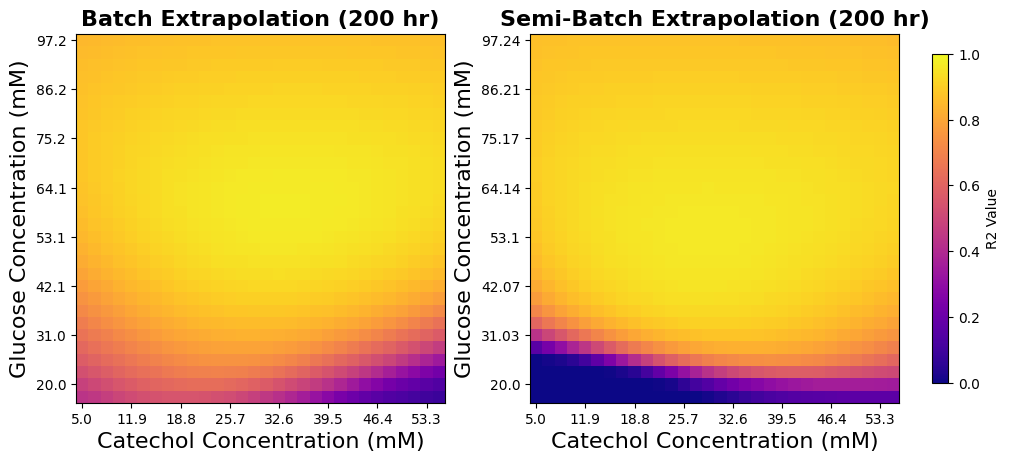

In [22]:
# The data made in the previous box
data1 = np.flipud(np.array(T_EX).reshape(30,30))
data2 = np.flipud(np.array(FB_EX).reshape(30,30))
cmap = "plasma"

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Set a common color scale
vmin = 0
vmax = 1

# Create heatmaps
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
im1 = axes[0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,1))
axes[0].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[0].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[0].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[0].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[0].set_title("Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
im2 = axes[1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,2))
axes[1].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[1].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[1].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[1].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[1].set_title("Semi-Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Add a common color bar
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('R2 Value')

In [23]:
final_dict = {}
final_dict["HMI_Extrapolation"] = np.array([T_EX, FB_EX])

# Improved hybrid model construction

The model training for the improved model was deconvoluated into two steps:
1) The time invaraint parameter estimation as the underlying phenom model 

2) The second time variant and ANN model training as the overarching hybrid model

The two step process was only possible because the incorporated physics would allow for the first step to occur accurately

## Step 1 - underlying PM construction

In [24]:
def dXtdt_PM_con(model, d, t):
     # Defines a constraint for the total biomass dynamics in an ODE system
    if t == 0:
        return Constraint.Skip # Skips the constraint at the initial time step
    # Computes the specific growth rate using an ANN model
    mu = ((model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1]))) 
    return model.dXtdt[d,t] == mu*model.conc_Xt[d,t] # Defines the biomass growth rate equation

def dCgdt_PM_con(model,d,t):
    # Defines a constraint for glucose concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip # Skips the constraint at the initial time step
    # Computes the specific growth rate using an ANN model
    mu = ((model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1])))
    # Defines the glucose consumption rate equation
    return model.dCgdt[d,t] == -1*model.conc_Xt[d,t]*(mu*model.Ygx)*(model.max_vals[0]/model.max_vals[1])

def dCmdt_PM_con(model,d,t):
    # Defines a constraint for muconic acid concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip # Skips the constraint at the initial time step
    # Computes the specific growth rate using an ANN model
    mu = ((model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1])))
     # Defines the muconic acid production rate equation
    return model.dCmdt[d,t] == (model.Ymx*mu + model.beta)*model.conc_Xt[d,t]*(
        (model.conc_Cc[d,t])/(model.conc_Cc[d,t] + (model.kc/model.max_vals[3])))*(model.max_vals[0]/model.max_vals[2])

def dCcdt_PM_con(model,d,t):
    # Defines a constraint for catechol concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip # Skips the constraint at the initial time step
    # Defines the catechol consumption rate equation
    return model.dCcdt[d,t] == -1*model.dCmdt[d,t]*(model.max_vals[2]/model.max_vals[3])

def objective_PM_SSmse(model):
    # Defines a state-space objective function for the integrated hybrid model
    # This function calculates the mean squared error (MSE) between measured and simulated concentrations
    final = 0  # Initializes the cumulative error
    # Loops over all spatial indices (d_idx) and measured time points (t_meas)
    for i in model.d_idx:
        for j in model.t_meas:
            # Accumulates squared errors for each state variable: biomass (Xt), glucose (Cg),
            # muconic acid (Cm), and catechol (Cc)
            final += (model.conc_Xt_meas[i, j] - model.conc_Xt[i, j])**2
            final += (model.conc_Cg_meas[i, j] - model.conc_Cg[i, j])**2
            final += (model.conc_Cm_meas[i, j] - model.conc_Cm[i, j])**2
            final += (model.conc_Cc_meas[i, j] - model.conc_Cc[i, j])**2
    # Computes the mean squared error by normalizing the total error
    # The denominator accounts for four state variables, the number of spatial indices, and time points
    fin = final / (4 * len(model.d_idx) * len(model.t_meas))
    return fin  # Returns the computed mean squared error

In [25]:
def make_PM_model_rs_fl(rs, fl):
    """
    This function generates a Pyomo model for a bioprocess using a hybrid ODE-ANN approach. 
    The function performs the following tasks:
    1. Generates training data with initial conditions and error added using predefined functions.
    2. Scales the data for model training.
    3. Defines a Pyomo model with sets, parameters, variables, and constraints based on the training data.
    4. Uses a solver to find optimal values for the model parameters.

    Parameters:
    - rs: Random seed for data generation (for reproducibility).
    - fl: Filename that contains initial conditions for the training data.

    Returns:
    - max_vals: The maximum values used for scaling the data.
    - model: The Pyomo model object representing the ODE-ANN system.
    """

    num = 10  # Number of time points per initial condition
    err = 10  # Percentage of Gaussian noise to be added
    rs = rs   # Use the random seed specified

    # Generate the synthetic training data using the functions `syn_data_generation` and `Error_addition`.
    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    # Collect data for each concentration (Xt, Cg, Cm, Cc) into a temporary list.
    y_temp = []
    for i in range(3):  # Loop for the first three species (Xt, Cg, Cm)
        y_temp.append(rc[i])

    # Convert the temporary data into numpy arrays for easier manipulation
    no_touch_y = np.array(y_temp)
    no_touch_t = np.copy(t)

    # Get the shape of the data (dimensions for species, datasets, and time points)
    n_d, n_s, n_t = np.shape(no_touch_y)

    # Extract the time and species data
    t = no_touch_t
    y_temp = no_touch_y
    max_vals = np.max(np.max(no_touch_y, axis=0), axis=1)  # Get the maximum values for scaling

    # Scale the data for training purposes
    y_scaled = np.zeros(np.shape(y_temp))

    # Create dictionaries for each concentration to store data in a format that Pyomo can use
    Xt_dict = {}
    Cg_dict = {}
    Cm_dict = {}
    Cc_dict = {}

    # Normalize each concentration by dividing by its max value
    for j in range(n_d):
        for i in range(n_t):
            Xt_dict[(j, t[i])] = y_temp[j, 0, i] / max_vals[0]
            y_scaled[j, 0, i] = y_temp[j, 0, i] / max_vals[0]

            Cg_dict[(j, t[i])] = y_temp[j, 1, i] / max_vals[1]
            y_scaled[j, 1, i] = y_temp[j, 1, i] / max_vals[1]

            Cm_dict[(j, t[i])] = y_temp[j, 2, i] / max_vals[2]
            y_scaled[j, 2, i] = y_temp[j, 2, i] / max_vals[2]

            Cc_dict[(j, t[i])] = y_temp[j, 3, i] / max_vals[3]
            y_scaled[j, 3, i] = y_temp[j, 3, i] / max_vals[3]

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Initialize the number of nodes for the model (currently set to 1)
    num_nodes = 1

    # Create an instance of the ConcreteModel for Pyomo
    model = ConcreteModel()

    # Define the sets for the model based on the dataset
    model.d_idx = Set(initialize = range(n_d))
    model.t_meas = Set(initialize = no_touch_t)

    # Define the parameters for the model based on the scaled training data
    model.max_vals = Param(range(4), initialize = max_vals)
    model.conc_Xt_meas = Param(model.d_idx, model.t_meas, initialize = Xt_dict)
    model.conc_Cg_meas = Param(model.d_idx, model.t_meas, initialize = Cg_dict)
    model.conc_Cm_meas = Param(model.d_idx, model.t_meas, initialize = Cm_dict)
    model.conc_Cc_meas = Param(model.d_idx, model.t_meas, initialize = Cc_dict)

    # Define the time-invariant variables (parameters) for the model
    model.mu_g = Var(within = NonNegativeReals)
    model.kg = Var(within = NonNegativeReals)
    model.Ygx = Var(within = NonNegativeReals)
    model.Ymx = Var(within = NonNegativeReals)
    model.beta = Var(within = NonNegativeReals)
    model.kc = Var(within = NonNegativeReals)

    # Define the variables for concentrations and their derivatives over time
    model.time = ContinuousSet(initialize = model.t_meas, bounds = (0,72))

    model.conc_Xt = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cg = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cm = Var(model.d_idx, model.time, within = NonNegativeReals)
    model.conc_Cc = Var(model.d_idx, model.time, within = NonNegativeReals)

    # Define the derivative variables for the concentrations
    model.dXtdt = DerivativeVar(model.conc_Xt, within = Reals)
    model.dCgdt = DerivativeVar(model.conc_Cg, within = Reals)
    model.dCmdt = DerivativeVar(model.conc_Cm, within = Reals)
    model.dCcdt = DerivativeVar(model.conc_Cc, within = Reals)

    # Add the hybrid ODE constraints for the model using predefined rules
    model.deriv_Xt = Constraint(model.d_idx, model.time, rule = dXtdt_PM_con)
    model.deriv_Cg = Constraint(model.d_idx, model.time, rule = dCgdt_PM_con)
    model.deriv_Cm = Constraint(model.d_idx, model.time, rule = dCmdt_PM_con)
    model.deriv_Cc = Constraint(model.d_idx, model.time, rule = dCcdt_PM_con)

    # Define the objective function for the model based on the state space MSE
    model.obj = Objective(expr = objective_PM_SSmse)

    # Use a transformation for discretization in Pyomo
    discretizer = TransformationFactory('dae.collocation')

    # Apply the discretization transformation to the model
    discretizer.apply_to(model, nfe=n_t, ncp=2, scheme='LAGRANGE-RADAU')

    # Solver setup: using the multistart solver to solve the model
    try:
        solver = SolverFactory("multistart")
        results = solver.solve(model, suppress_unbounded_warning=True, iterations=50)
    except:
        # In case of error, use the multistart solver again
        solver = SolverFactory("multistart")
        results = solver.solve(model, suppress_unbounded_warning=True)

    # Print solver results (status, termination condition, and objective value)
    print("Solver status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
    print(value(model.obj))
    
    # Return the maximum values used for scaling and the model itself
    return [max_vals, model]

In [26]:
def PM_TIV_params(model):
    # This function takes in a phenomenological Pyomo model
    # and it extracts the time-invariant parameters (TIV params).
    
    # Initialize an empty dictionary to store the extracted time-invariant parameters
    TIV_params = {}
    
    # Extract the values of the time-invariant parameters from the model
    TIV_params["mu_g"] = value(model.mu_g)  # Specific growth rate
    TIV_params["kg"] = value(model.kg)      # Glucose uptake rate
    TIV_params["Ygx"] = value(model.Ygx)    # Yield coefficient for glucose
    TIV_params["Ymx"] = value(model.Ymx)    # Yield coefficient for metabolite
    TIV_params["beta"] = value(model.beta)  # Rate of biomass decay
    TIV_params["kc"] = value(model.kc)      # Cell death rate
    
    # Return the dictionary containing the time-invariant parameters
    return TIV_params

## Step 2 - Improved hybrid model construction

In [27]:
def ANN_fv_model(model, d, t):
    # This function represents the integrated Artificial Neural Network (ANN) model.
    # It is embedded within the Pyomo formulation to model the fraction of viable cells in the biomass.

    # Get the concentrations of the state variables (biomass, glucose, metabolites, and cells) at time 't' for domain 'd'
    Xt = model.conc_Xt[d, t]  # Biomass concentration at time t
    Cg = model.conc_Cg[d, t]  # Glucose concentration at time t
    Cm = model.conc_Cm[d, t]  # Metabolite concentration at time t
    Cc = model.conc_Cc[d, t]  # Cell concentration at time t
    
    # Initialize a list to store the output of the hidden layer nodes (h1)
    h1_list = []

    # Loop through each hidden layer node to calculate its output
    for i in model.h1_num_nod:
        # Calculate the weighted sum of inputs plus the bias for the i-th hidden node
        z1 = model.W1[0, i] * Xt + model.W1[1, i] * Cg + model.W1[2, i] * Cm + model.W1[3, i] * Cc + model.b1[i]
        
        # Apply the sigmoid activation function to the weighted sum to get the hidden node output
        h1 = (1 / (1 + math.e ** (-1 * z1)))  # Sigmoid function (logistic function)
        
        # Append the hidden node output to the list
        h1_list.append(h1)
    
    # Calculate the output of the final layer (h3) which is a linear combination of the hidden nodes' outputs
    z2 = model.b2  # Initialize the bias for the output layer
    
    # Sum the weighted hidden layer outputs and add the bias
    for i in model.h1_num_nod:
        z2 += model.W2[i] * h1_list[i]
    
    # The output of the final layer is the model output h3
    h3 = z2
    
    return h3

In [28]:
def dXtdt_HM_con(model, d, t):
    # Defines a constraint for the total biomass dynamics in an ODE system
    if t == 0:
        return Constraint.Skip # Skips the constraint at the initial time step
    fv = ANN_fv_model(model,d,t) # Computes the fraction viable biomass using an ANN model
    mu = ((model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1])))
    return model.dXtdt[d,t] == mu*fv*model.conc_Xt[d,t] # Defines the biomass growth rate equation

def dCgdt_HM_con(model,d,t):
    # Defines a constraint for the total biomass dynamics in an ODE system
    if t == 0:
        return Constraint.Skip # Skips the constraint at the initial time step
    fv = ANN_fv_model(model,d,t) # Computes the fraction viable biomass using an ANN model
    mu = ((model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1])))
    # Defines the glucose consumption rate equation
    return model.dCgdt[d,t] == -1*fv*model.conc_Xt[d,t]*(mu*model.Ygx)*(model.max_vals[0]/model.max_vals[1])

def dCmdt_HM_con(model,d,t):
    # Defines a constraint for muconic acid concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip # Skips the constraint at the initial time step
    fv = ANN_fv_model(model,d,t) # Computes the fraction viable biomass using an ANN model
    mu = ((model.mu_g*model.conc_Cg[d,t])/(model.conc_Cg[d,t] + (model.kg/model.max_vals[1])))
    # Defines the muconic acid production rate equation
    return model.dCmdt[d,t] == (model.Ymx*mu + model.beta)*fv*model.conc_Xt[d,t]*(
        (model.conc_Cc[d,t])/(model.conc_Cc[d,t] + (model.kc/model.max_vals[3])))*(model.max_vals[0]/model.max_vals[2])

def dCcdt_HM_con(model,d,t):
    # Defines a constraint for catechol concentration dynamics in an ODE system
    if t == 0:
        return Constraint.Skip # Skips the constraint at the initial time step
    # Defines the catechol consumption rate equation
    return model.dCcdt[d,t] == -1*model.dCmdt[d,t]*(model.max_vals[2]/model.max_vals[3])

def objective_HM_SSmse(model):
    # Defines a state-space objective function for the integrated hybrid model
    # This function calculates the mean squared error (MSE) between measured and simulated concentrations
    final = 0  # Initializes the cumulative error
    # Loops over all spatial indices (d_idx) and measured time points (t_meas)
    for i in model.d_idx:
        for j in model.t_meas:
            # Accumulates squared errors for each state variable: biomass (Xt), glucose (Cg),
            # muconic acid (Cm), and catechol (Cc)
            final += (model.conc_Xt_meas[i, j] - model.conc_Xt[i, j])**2
            final += (model.conc_Cg_meas[i, j] - model.conc_Cg[i, j])**2
            final += (model.conc_Cm_meas[i, j] - model.conc_Cm[i, j])**2
            final += (model.conc_Cc_meas[i, j] - model.conc_Cc[i, j])**2
    # Computes the mean squared error by normalizing the total error
    # The denominator accounts for four state variables, the number of spatial indices, and time points
    fin = final / (4 * len(model.d_idx) * len(model.t_meas))
    return fin  # Returns the computed mean squared error

In [29]:
def make_HM_model_rs_fl(rs, fl, tdict):
    """
    This function generates a Pyomo model for a bioprocess using a hybrid ODE-ANN approach.
    The function performs the following tasks:
    1. Generates training data with initial conditions and error added using predefined functions.
    2. Scales the data for model training.
    3. Defines a Pyomo model with sets, parameters, variables, and constraints based on the training data.
    4. Uses a solver to find optimal values for the model parameters.

    Parameters:
    - rs: Random seed for data generation (for reproducibility).
    - fl: Filename that contains initial conditions for the training data.
    - tdict: Dictionary containing time-invariant parameters for the model.

    Returns:
    - max_vals: The maximum values used for scaling the data.
    - model: The Pyomo model object representing the ODE-ANN system.
    """

    num = 10  # Number of time points per initial condition
    err = 10  # Percentage of Gaussian noise to be added
    rs = rs   # Use the random seed specified

    # Generate synthetic training data and add error
    time, s = syn_data_generation(num, fl)
    t, rc = Error_addition(num, fl, err, rs)

    # Prepare data for Pyomo model
    y_temp = []
    for i in range(3):
        y_temp.append(rc[i])

    no_touch_y = np.array(y_temp)
    no_touch_t = np.copy(t)

    n_d, n_s, n_t = np.shape(no_touch_y)

    t = no_touch_t
    y_temp = no_touch_y
    max_vals = np.max(np.max(no_touch_y, axis=0), axis=1)

    y_scaled = np.zeros(np.shape(y_temp))

    # Convert training data from numpy arrays to dictionaries for Pyomo
    Xt_dict = {}
    Cg_dict = {}
    Cm_dict = {}
    Cc_dict = {}

    for j in range(n_d):
        for i in range(n_t):
            Xt_dict[(j, t[i])] = y_temp[j, 0, i] / max_vals[0]
            y_scaled[j, 0, i] = y_temp[j, 0, i] / max_vals[0]

            Cg_dict[(j, t[i])] = y_temp[j, 1, i] / max_vals[1]
            y_scaled[j, 1, i] = y_temp[j, 1, i] / max_vals[1]

            Cm_dict[(j, t[i])] = y_temp[j, 2, i] / max_vals[2]
            y_scaled[j, 2, i] = y_temp[j, 2, i] / max_vals[2]

            Cc_dict[(j, t[i])] = y_temp[j, 3, i] / max_vals[3]
            y_scaled[j, 3, i] = y_temp[j, 3, i] / max_vals[3]

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    num_nodes = 1  # Number of hidden nodes in the ANN

    # Initialize the Pyomo model
    model = ConcreteModel()

    # Sets describing the raw dataset
    model.d_idx = Set(initialize=range(n_d))  # Index for domains (initial conditions)
    model.t_meas = Set(initialize=no_touch_t)  # Time points

    # Sets and parameters describing the integrated ANN structure
    model.h1_num_nod = Set(initialize=range(num_nodes))  # Number of hidden nodes
    model.num_inputs = Set(initialize=range(n_s))  # Number of inputs (state variables)

    # Parameters - State Space data measurements
    model.max_vals = Param(range(4), initialize=max_vals)
    model.conc_Xt_meas = Param(model.d_idx, model.t_meas, initialize=Xt_dict)
    model.conc_Cg_meas = Param(model.d_idx, model.t_meas, initialize=Cg_dict)
    model.conc_Cm_meas = Param(model.d_idx, model.t_meas, initialize=Cm_dict)
    model.conc_Cc_meas = Param(model.d_idx, model.t_meas, initialize=Cc_dict)

    # Time-invariant parameters (obtained from tdict)
    model.mu_g = Param(initialize=tdict["mu_g"])
    model.kg = Param(initialize=tdict["kg"])
    model.Ygx = Param(initialize=tdict["Ygx"])
    model.Ymx = Param(initialize=tdict["Ymx"])
    model.beta = Param(initialize=tdict["beta"])
    model.kc = Param(initialize=tdict["kc"])

    # Variables - Concentrations and their derivatives
    model.time = ContinuousSet(initialize=model.t_meas, bounds=(0, 72))

    model.conc_Xt = Var(model.d_idx, model.time, within=NonNegativeReals)
    model.conc_Cg = Var(model.d_idx, model.time, within=NonNegativeReals)
    model.conc_Cm = Var(model.d_idx, model.time, within=NonNegativeReals)
    model.conc_Cc = Var(model.d_idx, model.time, within=NonNegativeReals)

    model.dXtdt = DerivativeVar(model.conc_Xt, within=Reals)
    model.dCgdt = DerivativeVar(model.conc_Cg, within=Reals)
    model.dCmdt = DerivativeVar(model.conc_Cm, within=Reals)
    model.dCcdt = DerivativeVar(model.conc_Cc, within=Reals)

    # Variables - ANN weights and biases
    model.W1 = Var(model.num_inputs, model.h1_num_nod, bounds=(-1, 1))  # Weights for the first layer
    model.b1 = Var(model.h1_num_nod, bounds=(-1, 1))  # Bias for the first layer
    model.W2 = Var(model.h1_num_nod, bounds=(-1, 1))  # Weights for the second layer
    model.b2 = Var(bounds=(-1, 1))  # Bias for the second layer

    # Constraints - Hybrid ODEs
    model.deriv_Xt = Constraint(model.d_idx, model.time, rule=dXtdt_HM_con)
    model.deriv_Cg = Constraint(model.d_idx, model.time, rule=dCgdt_HM_con)
    model.deriv_Cm = Constraint(model.d_idx, model.time, rule=dCmdt_HM_con)
    model.deriv_Cc = Constraint(model.d_idx, model.time, rule=dCcdt_HM_con)

    # Objective - State space Mean Squared Error (MSE)
    model.obj = Objective(expr=objective_HM_SSmse)

    # Descritizer for pyomo.dae (Discretization method for differential-algebraic equations)
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(model, nfe=n_t, ncp=2, scheme='LAGRANGE-RADAU')

    # Solver - multistart method
    try:
        solver = SolverFactory("multistart")
        results = solver.solve(model, suppress_unbounded_warning=True, iterations=50)
    except:
        solver = SolverFactory("multistart")
        results = solver.solve(model, suppress_unbounded_warning=True)

    # Output solver status and results
    print("Solver status:", results.solver.status)
    print("Termination Condition:", results.solver.termination_condition)
    print(value(model.obj))

    # Return the maximum values used for scaling and the Pyomo model object
    return [max_vals, model]

In [30]:
def TIV_and_ANN_ImHMI_params(model):
    """
    This function extracts the time-invariant parameters and ANN weights and biases
    from an integrated Pyomo model.
    
    Parameters:
    - model: The integrated Pyomo model containing both time-invariant parameters and ANN components.
    
    Returns:
    - A list containing:
        - TIV_params: A dictionary of time-invariant parameters (mu_g, kg, Ygx, Ymx, beta, kc).
        - ANN_params: A dictionary containing ANN weights (W1, W2), biases (b1, b2).
    """

    # Extract time-invariant parameters from the Pyomo model
    TIV_params = {}
    
    # Extract each time-invariant parameter and store it in the dictionary
    TIV_params["mu_g"] = value(model.mu_g)  # Growth rate
    TIV_params["kg"] = value(model.kg)      # Glucose uptake rate
    TIV_params["Ygx"] = value(model.Ygx)    # Yield coefficient for glucose to biomass
    TIV_params["Ymx"] = value(model.Ymx)    # Yield coefficient for biomass to maintenance
    TIV_params["beta"] = value(model.beta)  # Maintenance coefficient
    TIV_params["kc"] = value(model.kc)      # Specific consumption rate of substrate

    # Initialize a dictionary to store ANN parameters (weights and biases)
    ANN_params = {}

    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Initialize arrays to store the ANN weights (W1, W2) and biases (b1, b2)
    W1 = np.zeros((len(model.num_inputs), len(model.h1_num_nod)))  # Weights for the first layer
    b1 = np.zeros((len(model.h1_num_nod), 1))  # Biases for the first layer
    W2 = np.zeros((len(model.h1_num_nod), 1))  # Weights for the second layer

    # Extract the weights from the first layer (W1)
    for i in model.num_inputs:
        for j in model.h1_num_nod:
            W1[i, j] = value(model.W1[i, j])  # Extract weight for the connection between input i and hidden node j

    # Extract the biases for the first layer (b1)
    for i in model.h1_num_nod:
        b1[i] = value(model.b1[i])  # Extract bias for hidden node i

    # Extract the weights for the second layer (W2)
    for i in model.h1_num_nod:
        W2[i] = value(model.W2[i])  # Extract weight for the connection between hidden node i and output

    # Store the ANN parameters in the dictionary
    ANN_params["W1"] = W1  # Store the first layer weights
    ANN_params["b1"] = b1  # Store the first layer biases
    ANN_params["W2"] = W2  # Store the second layer weights
    ANN_params["b2"] = value(model.b2)  # Store the bias for the second layer
    
    # Return both TIV parameters and ANN parameters
    return [TIV_params, ANN_params]

## Improved hybrid model assembly and testing

In [31]:
def ANN_frac_via_model(y, ANN_params):
    """
    This function calculates the fraction of viable biomass using an Artificial Neural Network (ANN).
    The ANN takes inputs Xt, Cg, Cm, Cc (biomass concentration, glucose, metabolite, and cell concentration)
    along with the trained weights and biases to produce the output, which is the fraction of viable biomass.
    
    Parameters:
    - y: A tuple containing the input values (Xt, Cg, Cm, Cc).
      - Xt: Concentration of biomass
      - Cg: Glucose concentration
      - Cm: Metabolite concentration
      - Cc: Cell concentration
    - ANN_params: A dictionary containing the trained ANN weights (W1, W2) and biases (b1, b2).
    
    Returns:
    - h3: The output from the ANN representing the fraction of viable biomass.
    """
    
    # Unpack the input values
    Xt, Cg, Cm, Cc = y
    
    # Unpack the ANN parameters (weights and biases)
    W1 = ANN_params["W1"]  # Weights for the first layer
    b1 = ANN_params["b1"]  # Biases for the first layer
    W2 = ANN_params["W2"]  # Weights for the second layer
    b2 = ANN_params["b2"]  # Bias for the second layer
    
    # Initialize a list to store the outputs of the first hidden layer (h1)
    h1_list = []
    
    # Iterate through each hidden node in the first layer
    for i in range(np.shape(b1)[0]):
        # Calculate the weighted sum (z1) for the i-th hidden node
        z1 = W1[0,i]*Xt + W1[1,i]*Cg + W1[2,i]*Cm + W1[3,i]*Cc + b1[i,0]
        
        # Apply the sigmoid activation function to compute the output of the i-th hidden node (h1)
        h1 = (1 / (1 + math.e**(-1 * z1)))  # Sigmoid function (could also use tanh)
        
        # Append the result to the hidden layer list
        h1_list.append(h1)
    
    # Compute the weighted sum for the output layer (z2)
    z2 = b2  # Start with the bias term for the output layer
    for i in range(np.shape(W2)[0]):
        # Add the weighted sum of the hidden layer outputs (h1) to z2
        z2 += W2[i,0] * h1_list[i]
    
    # The final output is h3, which is the fraction of viable biomass
    h3 = z2
    
    return h3

In [32]:
def Imp_HM_ODE(t, y, param_dict, ANN_params, max_vals):
    """
    This function computes the derivatives of the system of ODEs for a hybrid model
    that describes the evolution of concentrations (Xt, Cg, Cm, Cc) over time.
    The model integrates both phenomenological kinetics and an Artificial Neural Network (ANN)
    to calculate the fraction of viable biomass (fv).

    Parameters:
    - t: The current time (not used in this function directly, but typically used in ODE solvers).
    - y: A list or array of concentrations [Xt, Cg, Cm, Cc] for biomass, glucose, metabolite, and cells.
    - param_dict: A dictionary containing the time-invariant parameters for the model.
    - ANN_params: The parameters of the ANN model used to calculate the fraction of viable biomass.
    - max_vals: A list of maximum values used for scaling the concentrations (for normalization).

    Returns:
    - A list of the derivatives [dXtdt, dCgdt, dCmdt, dCcdt], which represent the rate of change of the species over time.
    """

    # Unpack the input concentrations (Xt, Cg, Cm, Cc)
    Xt, Cg, Cm, Cc = y
    
    # Extract the time-invariant parameters from the dictionary
    mu_g = param_dict["mu_g"]
    kg = param_dict["kg"]
    Ygx = param_dict["Ygx"]
    Ymx = param_dict["Ymx"]
    beta = param_dict["beta"]
    kc = param_dict["kc"]
    
    # Use the ANN model to calculate the fraction of viable biomass
    fv = ANN_frac_via_model(y, ANN_params)
    # Calculate the specific growth rate (mu) using Monod kinetics for glucose
    mu = ((mu_g * Cg) / (Cg + (kg / max_vals[1])))
    
    # Differential equations based on the hybrid model
    # dXtdt: The rate of change of biomass concentration
    dXtdt = mu * fv * Xt
    # dCgdt: The rate of change of glucose concentration
    dCgdt = -1 * fv * Xt * (mu * Ygx) * (max_vals[0] / max_vals[1])
    # dCmdt: The rate of change of metabolite concentration
    dCmdt = (Ymx * mu + beta) * fv * Xt * (Cc / (Cc + (kc / max_vals[3]))) * (max_vals[0] / max_vals[2])
    # dCcdt: The rate of change of cell concentration
    dCcdt = -1 * dCmdt
    
    return [dXtdt, dCgdt, dCmdt, dCcdt]

In [33]:
def Imp_HM_Org_model_comparison_time(y0, tdict, adict, max_vals):
    """
    This function simulates the batch extrapolation scenario for a given
    initial condition using the improved hybrid ODE model and compares it
    against the ground truth model. It returns the mean R² value for the
    four species (Xt, Cg, Cm, Cc) between the predicted and actual concentrations.
    
    Parameters:
    - y0: Initial conditions for the species concentrations (Xt, Cg, Cm, Cc).
    - tdict: Time-invariant parameters for the model.
    - adict: ANN parameters used in the hybrid model.
    - max_vals: Maximum values used for scaling the data.

    Returns:
    - The mean R² value comparing the predicted and actual species concentrations.
    """

    # Extract initial concentrations
    y0 = y0
    y0_4 = np.delete(y0, 1)  # Remove the glucose concentration (Cg) from the initial condition

    # Time span for simulation
    tspan = (0, 200)

    # Simulate the ground truth model using the `combined_ode_system` (presumably a predefined ODE system)
    sol_actual = solve_ivp(combined_ode_system, tspan, y0, args=(y0[2],), 
                           method="Radau", t_eval=np.linspace(tspan[0], tspan[1], 60))
    y_actual = sol_actual.y
    y_actual[0, :] = y_actual[0, :] + y_actual[1, :]  # Combine Xt and Cg (assumed to be in the same concentration)
    y_actual = np.delete(y_actual, 1, axis=0)  # Remove the glucose concentration (Cg)

    # Scale the initial conditions before passing them to the improved hybrid model
    y0_scaled = np.divide(y0_4, max_vals)

    # Simulate the Imp_HM model using `Imp_HM_ODE`
    sol_predict = solve_ivp(Imp_HM_ODE, tspan, y0_scaled, args=(tdict, adict, max_vals), 
                            method="Radau", t_eval=np.linspace(tspan[0], tspan[1], 60))
    y_predict = np.multiply(sol_predict.y, max_vals.reshape(-1, 1))  # Rescale predictions

    # Calculate R² score for each species (Xt, Cm, Cc)
    r2_list = []
    try:
        for j in range(4):
            r2_list.append(r2_score(y_actual[j, :], y_predict[j, :]))
    except ValueError:
        r2_list = [0, 0, 0, 0]  # If error occurs (e.g., mismatched array lengths), return zero R² for each species
    
    # Return the mean R² score
    return np.mean(r2_list)

In [34]:
def Imp_HM_Org_model_comparison_FB(y0, tdict, adict, max_vals): 
    """
    Simulates the semi-batch extrapolation scenario for a given initial condition using the
    improved hybrid ODE model. The semi-batch includes periodic spikes of glucose and catechol 
    (10 mM glucose and 3 mM catechol every 25 hours). The function returns the mean R² score 
    between the integrated hybrid model and the ground truth model for the same initial conditions.
    
    Parameters:
    - y0: Initial conditions for the species concentrations (Xt, Cg, Cm, Cc).
    - tdict: Time-invariant parameters for the model.
    - adict: ANN parameters used in the hybrid model.
    - max_vals: Maximum values used for scaling the data.

    Returns:
    - The mean R² score comparing the predicted and actual species concentrations.
    """
    
    y0 = y0  # Initial conditions
    y0_4 = np.delete(y0, 1)  # Remove glucose concentration (Cg) from the initial condition
    tspan = (0, 200)  # Time span for the simulation
    
    # Initialize variables
    sol_list = []
    t_init = 0  # Initial time
    t_fin = 25  # Final time for each batch step
    count = 0
    y0_org = y0[2]  # Extract initial catechol concentration (Cm)
    
    # Simulate the ground truth model for each time window (25 hrs) with spikes
    while t_fin <= tspan[-1]:
        sol_actual = solve_ivp(
            combined_ode_system, (t_init, t_fin), y0, args=(y0_org + 10 * count,),
            method="Radau", t_eval=np.linspace(t_init, t_fin, 10)
        )
        
        sol_list.append(sol_actual)  # Save solution
        y0 = np.copy(sol_actual.y[:, -1])  # Update initial condition for the next step
        y0[2] += 10  # Add glucose spike
        y0[-1] += 3  # Add catechol spike

        # Update time range for next batch
        t_init += 25
        t_fin += 25

    # Aggregate the actual model results over the entire time span
    y = np.zeros((5, 80))
    t = []
    for i in range(len(sol_list)):
        s = 10 * i
        e = 10 * (i + 1)
        y[:, s:e] = sol_list[i].y  # Store the actual model results
        t.append(sol_list[i].t)  # Store the time steps

    t_actual = np.array(t).reshape(-1,)  # Flatten time array
    y_actual = np.copy(y)
    y_actual[0, :] = y_actual[0, :] + y_actual[1, :]  # Combine Xt and Cg
    y_actual = np.delete(y_actual, 1, axis=0)  # Remove glucose concentration

    # Simulate the hybrid model (Imp_HM) for the same time span with periodic spikes
    sol_list = []
    t_init = 0  # Reset time
    t_fin = 25  # Reset final time
    y_predict = np.zeros((4, 80))  # Initialize prediction matrix
    t = []
    c = 0

    # Simulate the Imp_HM model in the same way as the ground truth model
    while t_fin <= tspan[-1]:
        y0_scaled = np.divide(y0_4, max_vals)  # Scale the initial conditions
        sol_predict = solve_ivp(
            Imp_HM_ODE, (t_init, t_fin), y0_scaled, args=(tdict, adict, max_vals),
            method="Radau", t_eval=np.linspace(t_init, t_fin, 10)
        )
        y_pr = np.multiply(sol_predict.y, max_vals.reshape(-1, 1))  # Rescale predictions

        # Store predictions
        y_predict[:, 10 * c:10 * (c + 1)] = np.copy(y_pr)
        t.append(np.copy(sol_predict.t))  # Store time steps
        
        y0_4 = np.copy(y_pr[:, -1])  # Update initial condition for next time step
        y0_4[1] += 10  # Add glucose spike
        y0_4[-1] += 3  # Add catechol spike

        # Update time range for next batch
        t_init += 25
        t_fin += 25
        c += 1

    t_predict = np.array(t).reshape(-1, 1)  # Flatten time array for prediction

    # Compute R² scores for each species (Xt, Cm, Cc)
    r2_list = []
    for j in range(4):
        r2_list.append(r2_score(y_actual[j, :], y_predict[j, :]))  # R² score for each species

    # Return the mean R² score
    return np.mean(r2_list)

In [35]:
# This generates a list of initial conditions to test the 
# the batch and semi-batch extrapolation of the integrated
# hybrid model. 

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01

rect1_cg_cc = []

for i in range(30):
    for j in range(30):
        rect1_cg_cc.append(np.array([Xv_const, 0, Cg_range[i], 0, Cc_range[j]]))

In [36]:
# For different initial conditions and random seeds i.e traing data
# the batch and semi-batch extrapolation is tested and then stored 
# in dictionary

random_seed_list = [5, 10, 15, 20, 25]
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]
performance_dict = {}


for fl in range(len(file_list)):
    
    print(file_list[fl])
    perf_dict = {}
    
    for rs in range(len(random_seed_list)):
        
        try:
            max_vals1, PM_model_rs1 = make_PM_model_rs_fl(random_seed_list[rs], file_list[fl])
            tdict = PM_TIV_params(PM_model_rs1)
            max_vals, HM_model_rs1 = make_HM_model_rs_fl(random_seed_list[rs], file_list[fl], tdict)
           
        except ValueError:
            print("except")
            max_vals1, PM_model_rs1 = make_PM_model_rs_fl(random_seed_list[rs] + 1, file_list[fl])
            tdict = PM_TIV_params(PM_model_rs1)
            max_vals, HM_model_rs1 = make_HM_model_rs_fl(random_seed_list[rs] + 1, file_list[fl], tdict)
            


        tdict, adict = TIV_and_ANN_ImHMI_params(HM_model_rs1)

        rect_T_EX = []
        rect_FB_EX = []

        for i in range(900):
            rect_T_EX.append(Imp_HM_Org_model_comparison_time(rect1_cg_cc[i], tdict, adict, max_vals))
            rect_FB_EX.append(Imp_HM_Org_model_comparison_FB(rect1_cg_cc[i], tdict, adict, max_vals))

        perf_dict[random_seed_list[rs]] = [rect_T_EX, rect_FB_EX]
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    
    performance_dict[file_list[fl]] = perf_dict
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Initial_conditions_3_1_PP.txt
Solver status: ok
Termination Condition: optimal
0.0023625329452173433
Solver status: ok
Termination Condition: optimal
0.002321046542543439
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0029933159614905637
Solver status: ok
Termination Condition: optimal
0.0019744300110593658
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.002364662212347811
Solver status: ok
Termination Condition: optimal
0.00231498864234903
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.0028232883198523137
Solver status: ok
Termination Condition: optimal
0.0027988740745749706
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Solver status: ok
Termination Condition: optimal
0.003056468027237027
Solver status: ok
Termination Condition: optimal
0.003033447274869884
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Initial_conditions_3_2_PP.txt
Solver status: ok
Te

In [37]:
# This finds the average performance of the batch and
# semi-batch extrapolation for different initial conditions
# and random seed scenarios.

T_EX = []
FB_EX = []


for i in file_list:
    for j in random_seed_list:
        T_EX.append(performance_dict[i][j][0])
        FB_EX.append(performance_dict[i][j][1])


T_EX = np.array(T_EX)
FB_EX = np.array(FB_EX)

for i in range(np.shape(T_EX)[0]):
    for j in range(np.shape(T_EX)[1]):
        if T_EX[i,j] < 0:
            T_EX[i,j] = 0
        
        if FB_EX[i,j] < 0:
            FB_EX[i,j] = 0

T_EX = np.mean(np.array(T_EX), axis = 0)
FB_EX = np.mean(np.array(FB_EX), axis = 0)

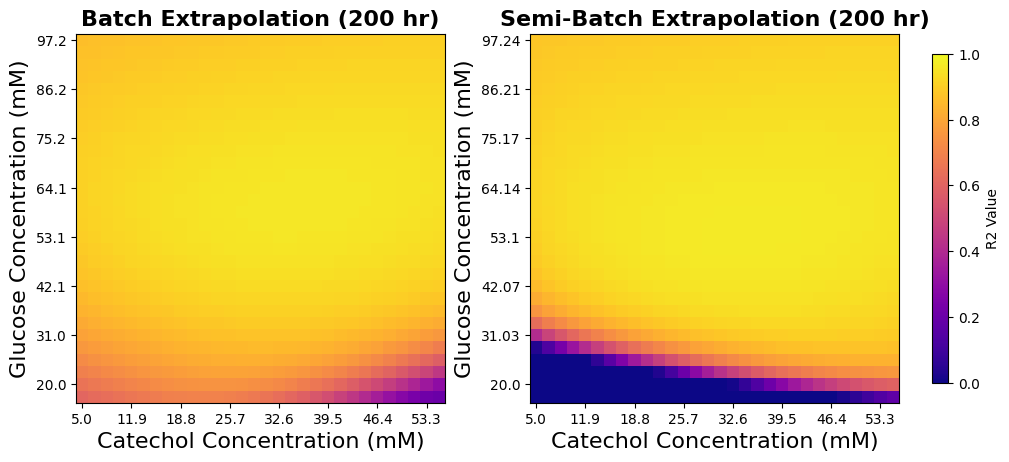

In [38]:
# Generate some example data for the heatmaps
data1 = np.flipud(np.array(T_EX).reshape(30,30))
data2 = np.flipud(np.array(FB_EX).reshape(30,30))
cmap = "plasma"

# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Set a common color scale
vmin = 0
vmax = 1

# Create heatmaps
im1 = axes[0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,1))
axes[0].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[0].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[0].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[0].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[0].set_title("Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

im2 = axes[1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
x_label = []
for i in Cc_range[::4]:
    x_label.append(round(i,1))
y_label = []
for i in np.flipud(Cg_range[::4]):
    y_label.append(round(i,2))
axes[1].set_xticks(ticks = np.arange(30)[::4], labels = x_label)
axes[1].set_yticks(ticks = np.arange(30)[::4], labels = y_label)
axes[1].set_xlabel("Catechol Concentration (mM)", fontsize = 16)
axes[1].set_ylabel("Glucose Concentration (mM)", fontsize = 16)
axes[1].set_title("Semi-Batch Extrapolation (200 hr)", fontsize = 16, fontweight = "bold")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Add a common color bar
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('R2 Value')

In [39]:
final_dict["ImHMI_Extrapolation"] = np.array([T_EX, FB_EX])

# Final Performance Evaluation

In [40]:
int_list = []
file_list = ["Initial_conditions_3_1_PP.txt",
            "Initial_conditions_3_2_PP.txt",
            "Initial_conditions_3_3_PP.txt",
            "Initial_conditions_3_4_PP.txt",
            "Initial_conditions_3_5_PP.txt"]

for i in file_list:
    fl = "Initial_conditions\\" + i
    int_list.append(np.loadtxt(fl))

In [41]:
a = np.array(int_list)

Cg_min = np.min(a[:,:,2])
Cc_min = np.min(a[:,:,-1])

Cg_max = np.max(a[:,:,2])
Cc_max = np.max(a[:,:,-1])

x_min = (30/50)*(Cc_min - 5)
x_max = (30/50)*(Cc_max - 5)

y_min = (30/80)*(Cg_min - 20)
y_max = (30/80)*(Cg_max - 20)

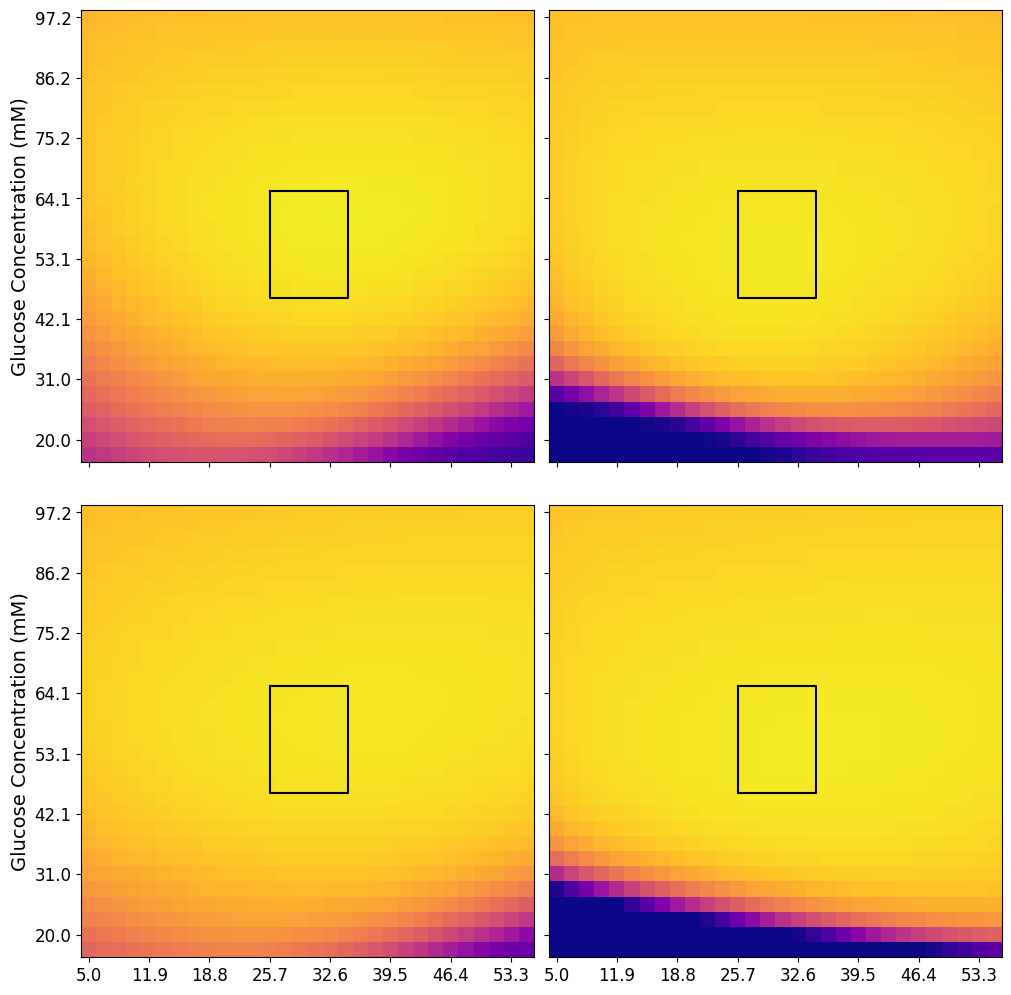

In [42]:
cmap = "plasma"
vmin = 0
vmax = 1
titles = {"HMI_Extrapolation" : "Original Hybrid", "ImHMI_Extrapolation" : "Improved Hybrid"}
keys = list(titles.keys())

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01


# Create a figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(10,10), constrained_layout=True, sharex = True, sharey = True)

for z in range(len(keys)):
    data1 =  np.flipud(final_dict[keys[z]][0].reshape(30,30))
    data2 =  np.flipud(final_dict[keys[z]][1].reshape(30,30))

    # Create heatmaps
    im1 = axes[z,0].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
    x_label = []
    for i in Cc_range[::4]:
        x_label.append(round(i,1))
    y_label = []
    for i in np.flipud(Cg_range[::4]):
        y_label.append(round(i,1))
    axes[z,0].set_xticks(ticks = np.arange(30)[::4], labels = x_label, fontsize = 12)
    axes[z,0].set_yticks(ticks = np.arange(30)[::4], labels = y_label, fontsize = 12)
    if z == 2: 
        axes[z,0].set_xlabel("Catechol Concentration (mM)", fontsize = 14)
    axes[z,0].set_ylabel("Glucose Concentration (mM)", fontsize = 14)
    axes[z,0].plot([x_min, x_max, x_max, x_min, x_min],[y_min, y_min, y_max, y_max, y_min ],"k")
    #axes[z,0].set_ylabel(titles[keys[z]], fontsize = 16, fontweight = "bold")

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    im2 = axes[z,1].imshow(data2, cmap= cmap, vmin=vmin, vmax=vmax)
    x_label = []
    for i in Cc_range[::4]:
        x_label.append(round(i,1))
    y_label = []
    for i in np.flipud(Cg_range[::4]):
        y_label.append(round(i,1))
    axes[z,1].set_xticks(ticks = np.arange(30)[::4], labels = x_label, fontsize = 12)
    axes[z,1].set_yticks(ticks = np.arange(30)[::4], labels = y_label, fontsize = 12)
    if z == 2:
        axes[z,1].set_xlabel("Catechol Concentration (mM)", fontsize = 14)
    axes[z,1].plot([x_min, x_max, x_max, x_min, x_min],[y_min, y_min, y_max, y_max, y_min ],"k")

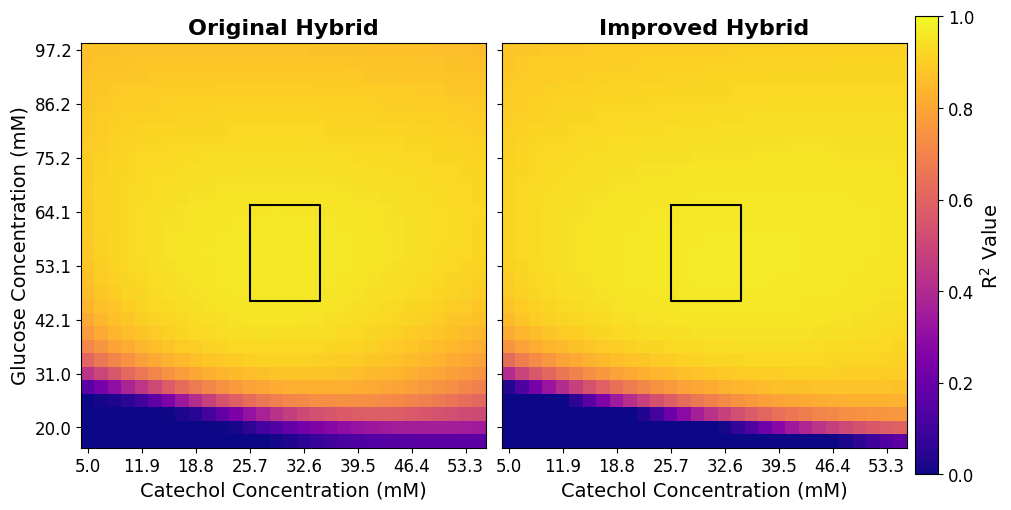

In [43]:
cmap = "plasma"
vmin = 0
vmax = 1
titles = {"HMI_Extrapolation" : "Original Hybrid", "ImHMI_Extrapolation" : "Improved Hybrid"}
keys = list(titles.keys())

Cg_range = np.linspace(20, 100, 30)
Cc_range = np.linspace(5, 55, 30)

Xv_const = 0.01


# Create a figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True, sharex = True, sharey = True)

for z in range(len(keys)):
    data1 =  np.flipud(final_dict[keys[z]][1].reshape(30,30))

    # Create heatmaps
    im1 = axes[z].imshow(data1, cmap= cmap, vmin=vmin, vmax=vmax)
    x_label = []
    for i in Cc_range[::4]:
        x_label.append(round(i,1))
    y_label = []
    for i in np.flipud(Cg_range[::4]):
        y_label.append(round(i,1))
    axes[z].set_xticks(ticks = np.arange(30)[::4], labels = x_label, fontsize = 12)
    axes[z].set_yticks(ticks = np.arange(30)[::4], labels = y_label, fontsize = 12) 
    axes[z].set_xlabel("Catechol Concentration (mM)", fontsize = 14)
    if z == 0:
        axes[z].set_ylabel("Glucose Concentration (mM)", fontsize = 14)
    axes[z].plot([x_min, x_max, x_max, x_min, x_min],[y_min, y_min, y_max, y_max, y_min ],"k")
    axes[z].set_title(titles[keys[z]], fontsize = 16, fontweight = "bold")


    # Add a common color bar
imz = im2
cbar = fig.colorbar(imz, ax=axes, orientation='vertical', fraction=0.07, pad=0.01)
cbar.set_label('R$^2$ Value', fontsize = 14)
cbar.ax.tick_params(labelsize = 12)

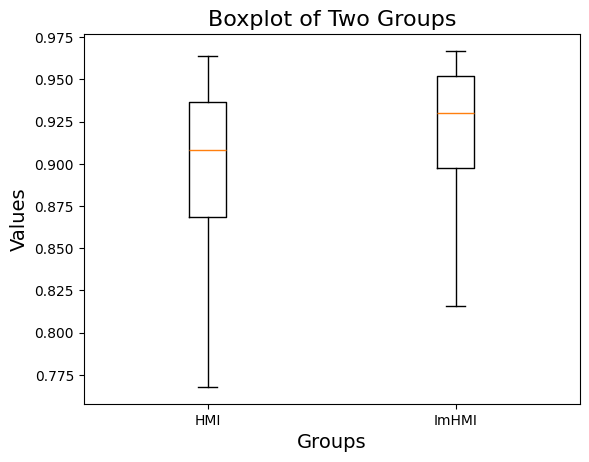

In [44]:
# Generate sample data for two groups
data1 = final_dict["HMI_Extrapolation"][1]  # Group 1 data
data2 = final_dict["ImHMI_Extrapolation"][1]

# Combine data into a list for plotting
data = [data1, data2]

# Create the boxplot
#plt.figure(figsize=(8, 6))  # Set figure size
plt.boxplot(data, labels=['HMI', "ImHMI"], showfliers = False)  # Add labels for the x-axis

# Add axis labels
plt.xlabel('Groups', fontsize=14)
plt.ylabel('Values', fontsize=14)

# Add a title (optional)
plt.title('Boxplot of Two Groups', fontsize=16)

# Show the plot
plt.show()

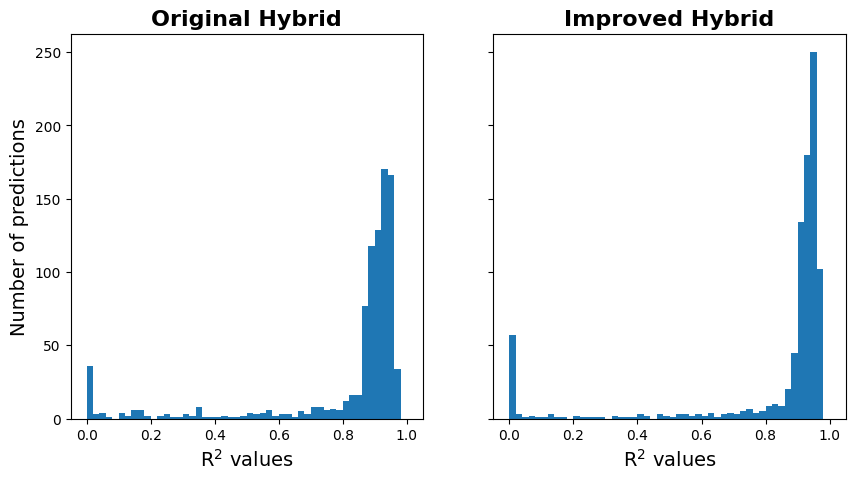

In [45]:
fig, axs = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
ax = axs.ravel()
n = 51

ax[0].hist(data1, bins = np.linspace(0,1,n))
ax[0].set_xlabel("R$^2$ values", fontsize = 14)
ax[0].set_title("Original Hybrid", fontweight = "bold", fontsize = 16)
ax[0].set_ylabel("Number of predictions", fontsize = 14)

ax[1].hist(data2, bins = np.linspace(0,1,n))
ax[1].set_xlabel("R$^2$ values", fontsize = 14)
ax[1].set_title("Improved Hybrid", fontweight = "bold", fontsize = 16)

plt.savefig("Improved_hybrid.svg")